# Stopped development beacuse of captcha :/
Maybe try on diffrent computer

1. 1st Method is to get flights there and back.
2. 2nd Method is to get price of one way ticket.

In [2]:
# -*- using Python 3.7 -*-

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time

# Round trip with set dates

Getting prices for exact dates

In [44]:
def scrape_round(origin, destination, startdate, days, requests):
    
    global results
    
    enddate = datetime.strptime(startdate, '%Y-%m-%d').date() + timedelta(days)
    enddate = enddate.strftime('%Y-%m-%d')

    url = "https://www.kayak.com/flights/" + origin + "-" + destination + "/" + startdate + "/" + enddate + "?sort=bestflight_a"
    print("\n" + url)

    chrome_options = webdriver.ChromeOptions()
    agents = ["Firefox/66.0.3","Chrome/73.0.3683.68","Edge/16.16299"]
    print("User agent: " + agents[(requests%len(agents))])
    chrome_options.add_argument('--user-agent=' + agents[(requests%len(agents))] + '"')    
    chrome_options.add_experimental_option('useAutomationExtension', False)
    
    #Headless - without graphic interface
    chrome_options.add_argument("--headless")
    
    driver = webdriver.Chrome(r'C:\Users\Lenovo\Desktop\PhotosScrapper\chromedriver.exe', options=chrome_options, desired_capabilities=chrome_options.to_capabilities())
    driver.implicitly_wait(20)
    driver.get(url)

    #Check if Kayak thinks that we're a bot
    time.sleep(5) 
    soup=BeautifulSoup(driver.page_source, 'lxml')

    if soup.find_all('p')[0].getText() == "Please confirm that you are a real KAYAK user.":
        print("Kayak thinks I'm a bot, which I am ... so let's wait a bit and try again")
        driver.close()
        time.sleep(1)
        return "failure"

    time.sleep(20) #wait 20sec for the page to load
    
    soup=BeautifulSoup(driver.page_source, 'lxml')
    
    #get the arrival and departure times
    deptimes = soup.find_all('span', attrs={'class': 'depart-time base-time'})
    arrtimes = soup.find_all('span', attrs={'class': 'arrival-time base-time'})
    meridies = soup.find_all('span', attrs={'class': 'time-meridiem meridiem'})
    
    deptime = []
    for div in deptimes:
        deptime.append(div.getText()[:-1])    
        
    arrtime = []
    for div in arrtimes:
        arrtime.append(div.getText()[:-1])   

    meridiem = []
    for div in meridies:
        meridiem.append(div.getText())  
        
    deptime = np.asarray(deptime)
    deptime = deptime.reshape(int(len(deptime)/2), 2)
    
    arrtime = np.asarray(arrtime)
    arrtime = arrtime.reshape(int(len(arrtime)/2), 2)      
    
    meridiem = np.asarray(meridiem)
    meridiem = meridiem.reshape(int(len(meridiem)/4), 4)
        
    #Get the price
    regex = re.compile('Common-Booking-MultiBookProvider (.*)multi-row Theme-featured-large(.*)')
    price_list = soup.find_all('div', attrs={'class': regex})
    
    price = []
    for div in price_list:
        price.append(int(div.getText().split('\n')[3][1:]))

    df = pd.DataFrame({"origin" : origin,
                       "destination" : destination,
                       "startdate" : startdate,
                       "enddate" : enddate,
                       "price": price,
                       "currency": "USD",
                       "deptime_o": [m+str(n) for m,n in zip(deptime[:,0],meridiem[:,0])],
                       "arrtime_d": [m+str(n) for m,n in zip(arrtime[:,0],meridiem[:,1])],
                       "deptime_d": [m+str(n) for m,n in zip(deptime[:,1],meridiem[:,2])],
                       "arrtime_o": [m+str(n) for m,n in zip(arrtime[:,1],meridiem[:,3])]
                       })

    results = pd.concat([results, df], sort=False)

    driver.close() #close the browser

    time.sleep(1) #wait 15sec until the next request
    
    return "success"         

In [45]:
#Create an empty dataframe 
results_round = pd.DataFrame(columns=['origin','destination','startdate','enddate','deptime_o','arrtime_d','deptime_d','arrtime_o','currency','price'])

requests = 0 

destinations = ['MSP']
startdates = ['2019-12-25']

for destination in destinations:
    for startdate in startdates:   
        requests = requests + 1
        while scrape_round('GDN', destination, startdate, 3, requests) != "success":
            requests = requests + 1
            
#Find the minimum price for each destination-startdate-combination
results_agg_round = results.groupby(['destination','startdate'])['price'].min().reset_index().rename(columns={'min':'price'})  


https://www.kayak.com/flights/GDN-MSP/2019-12-25/2019-12-28?sort=bestflight_a
User agent: Chrome/73.0.3683.68


In [52]:
results

,origin,destination,startdate,enddate,deptime_o,arrtime_d,deptime_d,arrtime_o,currency,price,$ price
0,GDN,MSP,2019-12-25,2019-12-28,11:45am,6:50pm,1:10pm,11:15am,USD,NaN,939.0
1,GDN,MSP,2019-12-25,2019-12-28,11:45am,6:50pm,3:35pm,5:35pm,USD,NaN,939.0
2,GDN,MSP,2019-12-25,2019-12-28,6:30am,6:50pm,1:10pm,11:15am,USD,NaN,939.0
3,GDN,MSP,2019-12-25,2019-12-28,11:45am,6:50pm,7:40pm,5:35pm,USD,NaN,1401.0
4,GDN,MSP,2019-12-25,2019-12-28,6:30am,12:54pm,1:10pm,11:15am,USD,NaN,1423.0
5,GDN,MSP,2019-12-25,2019-12-28,11:45am,12:26am,1:10pm,11:15am,USD,NaN,945.0
6,GDN,MSP,2019-12-25,2019-12-28,6:30am,6:50pm,3:35pm,5:35pm,USD,NaN,939.0
7,GDN,MSP,2019-12-25,2019-12-28,11:45am,12:26am,3:35pm,5:35pm,USD,NaN,945.0
8,GDN,MSP,2019-12-25,2019-12-28,6:30am,6:29pm,1:10pm,11:15am,USD,NaN,1090.0
9,GDN,MSP,2019-12-25,2019-12-28,11:45am,6:50pm,7:40pm,10:20pm,USD,NaN,1401.0


In [53]:
results_agg_round

,destination,startdate,price
0,MSP,2019-12-25,939


# One Way Ticket With Flexibility For 6 Days

Below function gives overview for one way ticket flights between 6 days.

In [32]:
def scrape_one_way(origin, destination, startdate, days, requests):
    
    global results
    
    #URL to kayak
    url = "https://www.kayak.com/flights/" + origin + "-" + destination + "/" + startdate + "-flexible" + "?sort=bestflight_a"
    print("\n" + url)

    #options to set selenium
    chrome_options = webdriver.ChromeOptions()
    
    #diffrent agents in case of Captcha
    agents = ["Firefox/66.0.3","Chrome/73.0.3683.68","Edge/16.16299"]
    print("User agent: " + agents[(requests%len(agents))])
    chrome_options.add_argument('--user-agent=' + agents[(requests%len(agents))] + '"')    
    chrome_options.add_experimental_option('useAutomationExtension', False)
    
    #Headless - without graphic interface
    chrome_options.add_argument("--headless")
    
    #path to driver
    driver = webdriver.Chrome(r'C:\Users\Lenovo\Desktop\PhotosScrapper\chromedriver.exe', options=chrome_options, desired_capabilities=chrome_options.to_capabilities())
    driver.implicitly_wait(20)
    driver.get(url)

    #Check if Kayak thinks that we're a bot
    time.sleep(5) 
    soup=BeautifulSoup(driver.page_source, 'lxml')

    if soup.find_all('p')[0].getText() == "Please confirm that you are a real KAYAK user.":
        print("Kayak thinks I'm a bot, which I am ... so let's wait a bit and try again")
        driver.close()
        time.sleep(20)
        return "failure"
    #If failure, change agent and wait
    
    time.sleep(20) #wait 20sec for the page to load
    
    soup=BeautifulSoup(driver.page_source, 'lxml')
    
    #get the departure day
    depdays = soup.find_all('div', attrs={'class': 'section date'})
    
    depday = []
    for div in depdays:
        depday.append(div.find('span').getText())  
    
    #get the arrival and departure times
    deptimes = soup.find_all('span', attrs={'class': 'depart-time base-time'})
    arrtimes = soup.find_all('span', attrs={'class': 'arrival-time base-time'})
    meridies = soup.find_all('span', attrs={'class': 'time-meridiem meridiem'})
    
    #obtaining particular times
    deptime = []
    for div in deptimes:
        deptime.append(div.getText()[:-1])    
        
    arrtime = []
    for div in arrtimes:
        arrtime.append(div.getText()[:-1])   

    meridiem = []
    for div in meridies:
        meridiem.append(div.getText())  
    
    #creating arrays with times
    deptime = np.asarray(deptime) 
    deptime = deptime.reshape(int(len(deptime)))
    
    arrtime = np.asarray(arrtime)    
    arrtime = arrtime.reshape(int(len(arrtime)))      
    
    meridiem = np.asarray(meridiem)
    meridiem = meridiem.reshape(int(len(meridiem)/2), 2)
    
    #Get the price
    regex = re.compile('Common-Booking-MultiBookProvider (.*)multi-row Theme-featured-large(.*)')
    price_list = soup.find_all('div', attrs={'class': regex})
    
    price = []
    for div in price_list:
        price.append(int(div.getText().split('\n')[3][1:]))

    df = pd.DataFrame({"origin" : origin,
                       "destination" : destination,
                       "startdate" : [m for m in depday],
                       "$ price": price,
                       "deptime_o": [m+str(n) for m,n in zip(deptime,meridiem[:,0])],
                       "arrtime_d": [m+str(n) for m,n in zip(arrtime,meridiem[:,1])],
                       })

    results = pd.concat([results, df], sort=False)

    driver.close() #close the browser

    time.sleep(15) #wait 15sec until the next request
    
    return "success"

In [ ]:
#Create an empty dataframe 
results_one_way = pd.DataFrame(columns=['origin','destination','startdate','deptime_o','arrtime_d','$ price'])

requests = 0 

destinations = ['MSP']
startdates = ['2019-12-25']

for destination in destinations:
    for startdate in startdates:   
        requests = requests + 1
        while scrape_one_way('GDN', destination, startdate, 3, requests) != "success":
            requests = requests + 1
            
#Find the minimum price for each destination-startdate-combination
results_agg_one_way = results.groupby(['destination','startdate'])['$ price'].min().reset_index().rename(columns={'min':'$ price'})           

In [25]:
results_one_way

,origin,destination,startdate,deptime_o,arrtime_d,$ price
0,GDN,MSP,12/25,2:55pm,11:09pm,827
1,GDN,MSP,12/25,6:35am,12:28am,434
2,GDN,MSP,12/27,10:20am,4:55pm,844
3,GDN,MSP,12/23,8:05am,4:55pm,820
4,GDN,MSP,12/23,7:00am,5:05pm,705
5,GDN,MSP,12/23,8:05am,5:05pm,798
6,GDN,MSP,12/25,2:55pm,11:09pm,818
7,GDN,MSP,12/26,2:55pm,11:09pm,827
8,GDN,MSP,12/28,2:55pm,11:09pm,846
9,GDN,MSP,12/27,2:55pm,11:09pm,846


In [31]:
results_agg_one_way

,destination,startdate,$ price
0,MSP,12/22,846
1,MSP,12/23,705
2,MSP,12/25,434
3,MSP,12/26,827
4,MSP,12/27,844
5,MSP,12/28,794


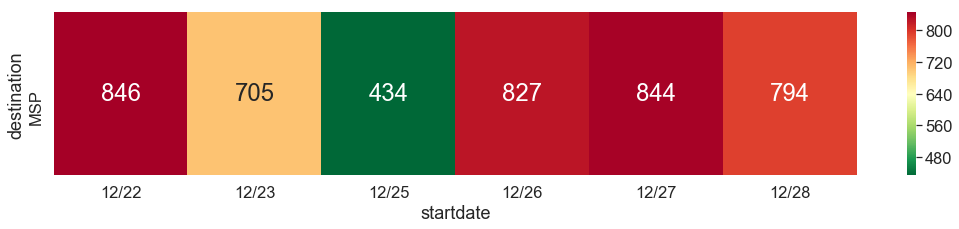

In [30]:
heatmap_results = pd.pivot_table(results_agg , values='$ price', 
                     index=['destination'], 
                     columns='startdate')
                     
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)d
plt.figure(figsize = (18,3))
sns.heatmap(heatmap_results, annot=True, annot_kws={"size": 24}, fmt='.0f', cmap="RdYlGn_r")